In [14]:
from tree_detection_framework.preprocessing.preprocessing import create_dataloader, visualize_dataloader
from tree_detection_framework.detection.detector import DeepForestModule, LightningDetector
from torch.utils.data import DataLoader
from torchgeo.datasets import IntersectionDataset, stack_samples, unbind_samples
from torchgeo.samplers import GridGeoSampler, Units
from torchvision.transforms import ToPILImage

from tree_detection_framework.constants import ARRAY_TYPE, BOUNDARY_TYPE, PATH_TYPE
from tree_detection_framework.preprocessing.derived_geodatasets import (
    CustomRasterDataset,
    CustomVectorDataset,
)
from torchgeo.datamodules import GeoDataModule

In [15]:
from torchgeo.datasets import RasterDataset, VectorDataset
import lightning

In [16]:
class CustomDataModule(GeoDataModule):
    def __init__(self, dataset_class, raster_folder_path, vector_folder_path, output_res, vector_label_name):
        super().__init__(dataset_class=dataset_class)
        self.raster_folder_path = raster_folder_path
        self.vector_folder_path = vector_folder_path
        self.output_res = output_res
        self.vector_label_name = vector_label_name

    def setup(self, stage=None):
        self.raster_data = CustomRasterDataset(
            paths=self.raster_folder_path, 
            res=self.output_res
        )
        self.vector_data = CustomVectorDataset(
            paths=self.vector_folder_path,
            res=self.output_res,
            label_name=self.vector_label_name,
        )
        if stage == 'fit':
            self.train_data = self.raster_data & self.vector_data
        if stage == 'validate' or stage == 'fit':
            self.val_data = self.raster_data & self.vector_data
        if stage == 'test':
            self.test_data = self.raster_data & self.vector_data

    def train_dataloader(self):
        self.train_data = self.raster_data & self.vector_data
        sampler = GridGeoSampler(self.train_data, size=512, stride=400)
        return DataLoader(self.train_data, sampler=sampler, collate_fn=stack_samples)

    def val_dataloader(self):
        sampler = GridGeoSampler(self.val_data, size=100, stride=50, units=Units.CRS)
        return DataLoader(self.val_data, sampler=sampler, collate_fn=stack_samples)

    def test_dataloader(self):
        sampler = GridGeoSampler(self.test_data, size=100, stride=50, units=Units.CRS)
        return DataLoader(self.test_data, sampler=sampler, collate_fn=stack_samples)

    def on_after_batch_transfer(self, batch, dataloader_idx: int):
        return batch


In [17]:
datamodule = CustomDataModule(
    dataset_class = RasterDataset,
    raster_folder_path='/ofo-share/scratch-amritha/emerald_point_dtree2/dataset/emerald-point-ortho',
    vector_folder_path='/ofo-share/scratch-amritha/emerald_point_dtree2/dataset/crowns',
    output_res=0.2,
    vector_label_name='treeID'
)

In [18]:
datamodule.setup()

In [19]:
train_dataloader = datamodule.train_dataloader()

In [20]:
all_batches = list(train_dataloader)

/ofo-share/repos-amritha/conda/envs/tree-detection-framework/lib/python3.10/site-packages/rasterio/merge.py:369: NodataShadowWarning: The dataset's nodata attribute is shadowing the alpha band. All masks will be determined by the nodata attribute
  temp_src = src.read(
/ofo-share/repos-amritha/conda/envs/tree-detection-framework/lib/python3.10/site-packages/rasterio/merge.py:369: NodataShadowWarning: The dataset's nodata attribute is shadowing the alpha band. All masks will be determined by the nodata attribute
  temp_src = src.read(
/ofo-share/repos-amritha/conda/envs/tree-detection-framework/lib/python3.10/site-packages/rasterio/merge.py:369: NodataShadowWarning: The dataset's nodata attribute is shadowing the alpha band. All masks will be determined by the nodata attribute
  temp_src = src.read(
/ofo-share/repos-amritha/conda/envs/tree-detection-framework/lib/python3.10/site-packages/rasterio/merge.py:369: NodataShadowWarning: The dataset's nodata attribute is shadowing the alpha ba

In [30]:
image_tensor = all_batches[0]['image'][:, :3, :, :] / 255.0

In [44]:
boxes = all_batches[0]['label_bboxes']

In [46]:
boxes

[[[139.2904516342096,
   391.19868682324886,
   188.99876417592168,
   440.87216721475124],
  [66.56408311286941,
   414.75419517979026,
   88.85055981948972,
   438.5171918012202],
  [102.77901602303609,
   422.2890706397593,
   115.42163382237777,
   435.0238514728844],
  [210.4031415330246,
   392.4552073813975,
   234.80103473132476,
   435.5978427119553],
  [9.507259087171406,
   392.96575225517154,
   42.55524547211826,
   426.11659513786435],
  [101.02875383710489,
   409.84012723341584,
   117.07761968672276,
   422.29734482988715],
  [39.062565674073994,
   391.31634456664324,
   69.60520937060937,
   420.6501219943166],
  [165.5832846639678,
   360.6080938503146,
   217.79480880638584,
   412.8768054507673],
  [60.08324642200023,
   365.95617689192295,
   99.09484198270366,
   398.87303925678134],
  [149.76333718420938,
   357.09837901592255,
   186.55324816843495,
   392.5788340754807],
  [69.10958515945822,
   325.0841693021357,
   118.97740621352568,
   383.43912751600146]

In [45]:
import torch

# Convert to a flat list of boxes
flat_bboxes = [bbox for sublist in boxes for bbox in sublist]

boxes_tensor = torch.FloatTensor(flat_bboxes)  # Shape will be [N, 4]

print(boxes_tensor)

tensor([[ 1.3929e+02,  3.9120e+02,  1.8900e+02,  4.4087e+02],
        [ 6.6564e+01,  4.1475e+02,  8.8851e+01,  4.3852e+02],
        [ 1.0278e+02,  4.2229e+02,  1.1542e+02,  4.3502e+02],
        [ 2.1040e+02,  3.9246e+02,  2.3480e+02,  4.3560e+02],
        [ 9.5073e+00,  3.9297e+02,  4.2555e+01,  4.2612e+02],
        [ 1.0103e+02,  4.0984e+02,  1.1708e+02,  4.2230e+02],
        [ 3.9063e+01,  3.9132e+02,  6.9605e+01,  4.2065e+02],
        [ 1.6558e+02,  3.6061e+02,  2.1779e+02,  4.1288e+02],
        [ 6.0083e+01,  3.6596e+02,  9.9095e+01,  3.9887e+02],
        [ 1.4976e+02,  3.5710e+02,  1.8655e+02,  3.9258e+02],
        [ 6.9110e+01,  3.2508e+02,  1.1898e+02,  3.8344e+02],
        [ 1.9631e+02,  3.2281e+02,  2.4489e+02,  3.8183e+02],
        [ 4.6866e+01,  3.0715e+02,  8.6973e+01,  3.6673e+02],
        [-9.3132e-10,  3.1381e+02,  4.0334e+01,  3.6537e+02],
        [ 1.0996e+02,  3.3178e+02,  1.4286e+02,  3.5447e+02],
        [ 2.0960e+02,  3.2027e+02,  2.4664e+02,  3.4179e+02],
        

In [47]:
boxes_tensor.shape

torch.Size([201, 4])

In [50]:
torch.any(boxes_tensor < 0)

tensor(True)

In [51]:
valid_mask = (boxes_tensor >= 0).all(dim=1)  # Check if all values in each box are non-negative

# Filter the boxes_tensor using the valid mask
filtered_boxes_tensor = boxes_tensor[valid_mask]

print(filtered_boxes_tensor.shape)
print(torch.any(filtered_boxes_tensor < 0))

torch.Size([188, 4])
tensor(False)


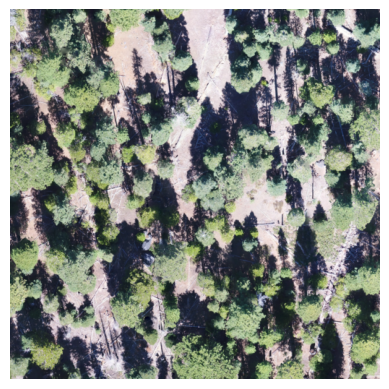

In [32]:
import matplotlib.pyplot as plt

image_np = image_tensor.squeeze().numpy()

# Transpose the dimensions from (C, H, W) to (H, W, C)
image_np = image_np.transpose(1, 2, 0)


plt.imshow(image_np)
plt.axis('off')
plt.show()

In [38]:
batch = all_batches[0]

In [42]:
batch['image'].shape

torch.Size([1, 4, 512, 512])